# Analysis
* This notebook cleans code for analyzing 'parsed1.csv'
* Contains some preliminary analysis.

In [14]:
import ast
import itertools
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regex as re
import seaborn as sns

from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv("parsed1.csv", index_col = 0)
df.drop(columns = ['docket_no'], inplace = True)

In [3]:
df.head()

,offenses,offense_date,arrest_dt,case_status,arresting_officer,attorney,dob,zip,bail_set_by,bail_amount,bail_paid,bail_date,bail_type,prelim_hearing_dt,prelim_hearing_time,parsed_offenses
0,"['Rape Forcible Compulsion', 'Rape Forcible Co...",5/28/20,7/27/20,Active,"Bengochea, William",Defender Association of Philadelphia,5/19/93,19123,"Bernard, Francis X.",300000,0,7/28/20,Monetary,7/28/20,4:49 AM,"['False Imprisonment', 'Indec Asslt-W/O Cons O..."
1,['Aggravated Assault - Attempts to cause SBI o...,5/4/20,5/4/20,Active,"Soares, Baldomiro J. Jr.",Defender Association of Philadelphia,5/5/97,19121,E-Filing Judge,50000,5000,5/5/20,Monetary,5/4/20,5:33 PM,['Aggravated Assault - Attempts to cause SBI o...
2,"['Simple Assault', 'Simple Assault', 'Reckless...",2/2/20,2/12/20,Active,"Jones, James",Defender Association of Philadelphia,11/15/86,19124,"Stack, Patrick",7500,750,2/13/20,Monetary,2/13/20,8:22 AM,"['Recklessly Endangering Another Person', 'Sim..."
3,"['Contraband/Controlled Substance', 'Contraban...",2/10/20,2/21/20,Active,"Balmer, James M.",Defender Association of Philadelphia,12/13/80,19135,"Bernard, Francis X.",5000,0,2/21/20,Unsecured,2/21/20,8:34 PM,"['Contraband/Controlled Substance', 'Int Poss ..."
4,"['Manufacture, Delivery, or Possession With In...",3/13/20,3/14/20,Active,"Sima, Raymond",Richard T. Brown Jr.,11/5/97,19144,"Stack, Patrick",0,0,3/14/20,ROR,3/14/20,8:40 AM,"['Conspiracy', 'Int Poss Contr Subst By Per No..."


In [4]:
# convert string to datetime
#df["offense_date"] = pd.to_datetime(df["offense_date"])
df["arrest_dt"] = pd.to_datetime(df["arrest_dt"])
df["dob"] = pd.to_datetime(df["dob"])
df["bail_date"] = pd.to_datetime(df["bail_date"])
df["prelim_hearing_dt"] = pd.to_datetime(df["prelim_hearing_dt"])

# age column
df['age'] = df['dob'].apply(lambda x: 2020-x.year)

# public defender column: 1 if public defender, 0 if private defender
df["public_defender"] = df["attorney"].apply(lambda x: 1 if x =='Defender Association of  Philadelphia' else 0)

# convert type of "offenses" and "parsed_offenses" from string representation of list to list
df["offenses"] = df["offenses"].apply(lambda x: ast.literal_eval(x))
df["parsed_offenses"] = df["parsed_offenses"].apply(lambda x: ast.literal_eval(x))

# zipcode: remove everything after hyphen
df["zipcode_clean"] = df["zip"].apply(lambda x: re.sub('-.*$','',x) if type(x) == str else x)

# Create column indicating whether zipcode is in philadelphia or not
philly_zipcode = list(range(19102, 19155))
philly_zipcode = [str(item) for item in philly_zipcode]
df['philly_zipcode'] = df['zipcode_clean'].apply(lambda x: 1 if x in philly_zipcode else 0)

Note:
* For some reason, 'offense date' has multiple formats, so I couldn't easily convert to datetime format. Hopefully, the newly parsed dockets will all have uniform date format.

In [13]:
# save
# df.to_csv("../Data/parsed1_cleaned.csv")

# Import and preprocessing for updated csv's

In [2]:
# Import and join docket and court summary csv files
docketdf = pd.read_csv("docket-parsed.csv", index_col=0)
courtdf = pd.read_csv("court-parsed.csv", index_col=0)
new = docketdf.merge(courtdf, on='docket_no', how='left', suffixes=('', '_y'))
new.reset_index(inplace=True)
new.drop(columns=['docket_no'], inplace=True)
new.drop(new.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [3]:
# convert string to datetime
new["offense_date"] = pd.to_datetime(new["offense_date"])
new["arrest_dt"] = pd.to_datetime(new["arrest_dt"])
new["dob"] = pd.to_datetime(new["dob"])
new["bail_date"] = pd.to_datetime(new["bail_date"])
new["prelim_hearing_dt"] = new["prelim_hearing_dt"].apply(
    lambda x: str(x).split(' ')[0] if pd.notnull(x) else x) # This is here because of a parsing issue
new["prelim_hearing_dt"] = pd.to_datetime(new["prelim_hearing_dt"])
new["prelim_hearing_time"] = pd.to_datetime(new["prelim_hearing_time"])

# age column
new['age'] = new['arrest_dt'] - new['dob']
new['age'] = new['age'].apply(lambda x: np.floor(x.days/365.2425))

# public defender column: 1 if public defender, 0 if private defender
# note that there is also an "attorney_type" column, with "Public", "Private", and "Court Appointed" options
new["public_defender"] = new["attorney"].apply(lambda x: 1 if x =='Defender Association of  Philadelphia' else 0)

# convert string representation of list to list
new["offenses"] = new["offenses"].apply(lambda x: ast.literal_eval(x))
new['offense_type'] = new['offense_type'].apply(lambda x: ast.literal_eval(x))
new['statute'] = new['statute'].apply(lambda x: ast.literal_eval(x))

# zipcode: remove everything after hyphen
new["zipcode_clean"] = new["zip"].apply(lambda x: re.sub('-.*$','',x) if type(x) == str else x)

# column indicating whether zipcode is in Philadelphia
philly_zipcode = list(range(19102, 19155))
philly_zipcode = [str(item) for item in philly_zipcode]
new['philly_zipcode'] = new['zipcode_clean'].apply(lambda x: 1 if x in philly_zipcode else 0)

# categorical column indicating if bail is paid
new['bail_paid_YN'] = new['bail_paid'].apply(lambda x: "no" if x == 0 else "yes")

In [4]:
# Define bins for bail amount
def bin_bailSet(bailSet):
    if bailSet == 0 or pd.isnull(bailSet):
        return 'None'
    elif bailSet < 1000:
        return '<1k'
    elif bailSet < 5000:
        return '1k to 5k'
    elif bailSet < 10000:
        return '5k to 10k'
    elif bailSet < 25000:
        return '10k to 25k'
    elif bailSet < 50000:
        return '25k to 50k'
    elif bailSet < 100000:
        return '50k to 100k'
    elif bailSet < 500000:
        return '100k to 500k'
    else:
        return '>=500k'

# TODO: auto-generate bail_bin_labels to not have to manually update if updating fcn above
bail_bin_labels = ['None', '<1k', '1k to 5k', '5k to 10k', '10k to 25k', '25k to 50k', '50k to 100k', '100k to 500k', '>=500k']   
    
# column for bail amount bins
new['bail_set_bin'] = new['bail_amount'].apply(lambda x: bin_bailSet(x))

In [5]:
# Define bins for age group
def bin_age(age):
    if age < 18:
        return 'minor'
    elif age < 26:
        return '18 to 25'
    elif age < 34:
        return '26 to 33'
    elif age < 42:
        return '34 to 41'
    elif age < 50:
        return '42 to 49'
    elif age < 58:
        return '50 to 57'
    elif age < 65:
        return '58 to 64'
    else:
        return 'senior'

# column for bail amount bins
new['age_group'] = new['age'].apply(lambda x: bin_age(x))

In [6]:
# remove arrests that occurred between 5/31 - 6/3 (BLM movement)
new = new[(new['arrest_dt'] < np.datetime64('2020-05-31')) | (new['arrest_dt'] > np.datetime64('2020-06-03'))]
new.reset_index(drop = True, inplace = True)

In [7]:
# full list of columns available to work with
sorted(new.columns.tolist())

['age',
 'age_group',
 'arrest_dt',
 'arresting_officer',
 'attorney',
 'attorney_type',
 'bail_amount',
 'bail_date',
 'bail_paid',
 'bail_paid_YN',
 'bail_set_bin',
 'bail_set_by',
 'bail_type',
 'case_status',
 'dob',
 'offense_date',
 'offense_type',
 'offenses',
 'philly_zipcode',
 'prelim_hearing_dt',
 'prelim_hearing_time',
 'public_defender',
 'race',
 'sex',
 'statute',
 'zip',
 'zipcode_clean']

In [8]:
new.head()

,attorney,attorney_type,offenses,offense_date,statute,offense_type,bail_set_by,bail_amount,bail_paid,bail_date,...,prelim_hearing_time,sex,race,age,public_defender,zipcode_clean,philly_zipcode,bail_paid_YN,bail_set_bin,age_group
0,Defender Association of Philadelphia,Public,"[DUI: Gen Imp/Inc of Driving Safely - 1st Off,...",2019-12-31,"[75 § 3802, 75 § 3323]",[driving after imbibing alcohol or utilizing d...,"Bernard, Francis X.",0.0,0.0,2020-01-01,...,2020-12-17 04:05:00,Male,White,25.0,0,19115,1,no,None,18 to 25
1,Joseph Kevin Kelly,Private,[DUI: Gen Imp/Inc of Driving Safely - 1st Off],2019-12-31,[75 § 3802],[driving after imbibing alcohol or utilizing d...,"Bernard, Francis X.",0.0,0.0,2020-01-01,...,2020-12-17 04:07:00,Male,White,24.0,0,19134,1,no,None,18 to 25
2,Defender Association of Philadelphia,Public,[Retail Theft-Take Mdse],2019-12-31,[18 § 3929],[theft and related offenses],"Bernard, Francis X.",0.0,0.0,2020-01-01,...,2020-12-17 04:10:00,Male,Black,57.0,0,19131,1,no,None,50 to 57
3,Defender Association of Philadelphia,Public,"[Simple Assault, Recklessly Endangering Anothe...",2019-12-31,"[18 § 2701, 18 § 2705]","[assault, assault]","Bernard, Francis X.",30000.0,0.0,2020-01-01,...,2020-12-17 04:15:00,Male,Black,32.0,0,19121,1,no,25k to 50k,26 to 33
4,Lee Mandell,Court Appointed,"[Robbery-Inflict Threat Imm Bod Inj, Conspirac...",2019-12-31,"[18 § 3701 §§ A1IV, 18 § 903 §§ C, 18 § 3921 §...","[robbery, inchoate crimes, theft and related o...","Pittman, Joffie C. III",30000.0,0.0,2020-01-09,...,2020-12-17 08:39:00,Male,Black,18.0,0,19135,1,no,25k to 50k,18 to 25


## Preliminary analysis

In [5]:
df["public_defender"].value_counts()

1    9148
0    4290
Name: public_defender, dtype: int64

In [6]:
df["bail_type"].value_counts()

Monetary       5534
ROR            3920
Unsecured      3622
Nonmonetary     156
Nominal           1
Name: bail_type, dtype: int64

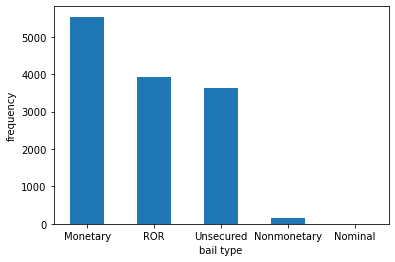

In [9]:
# types of bail
fig, ax = plt.subplots()
ax = df['bail_type'].value_counts().plot(kind = 'bar')
ax.set_xlabel('bail type')
ax.set_ylabel('frequency')
ax.xaxis.set_tick_params(rotation=0)
plt.show()

<b> Bail amount for monetary bail </b>

In [10]:
df[df["bail_type"] == "Monetary"].bail_amount.describe()

count    5.534000e+03
mean     9.940039e+04
std      2.404077e+05
min      0.000000e+00
25%      1.000000e+04
50%      2.500000e+04
75%      1.000000e+05
max      5.000000e+06
Name: bail_amount, dtype: float64

In [11]:
# median bail amount
print('median bail amount: ', df[df["bail_type"] == "Monetary"].bail_amount.median())

median bail amount:  25000.0


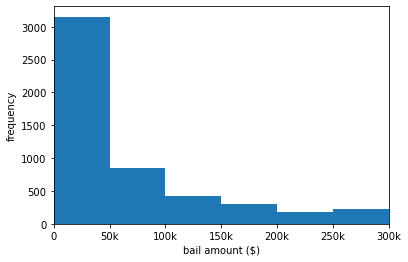

In [12]:
# distribution of bail amount for monetary bail
fig, ax = plt.subplots()
ax = df[df["bail_type"] == "Monetary"].bail_amount.plot.hist(bins = 100)
ax.set_xlim((0,300000))
ax.set_xlabel('bail amount ($)')
ax.set_ylabel('frequency')
plt.xticks(range(0, 350000, 50000), ['0','50k', '100k', '150k', '200k', '250k', '300k'])
plt.show()

In [ ]:
# median bail amount over time 

<b> Quesiton:</b> When a bail is paid, is it always 10% of the bail amount? Yes

In [13]:
# when a bail is paid, it's always 10% of the bail amount
(df[df["bail_paid"] > 0].bail_amount * 0.1 == df[df["bail_paid"] > 0].bail_paid).value_counts()

True    3005
dtype: int64

<b> Number of cases over time </b>

In [23]:
day_count = df['arrest_dt'].value_counts()
day_count.keys().max()

Timestamp('2020-07-29 00:00:00')

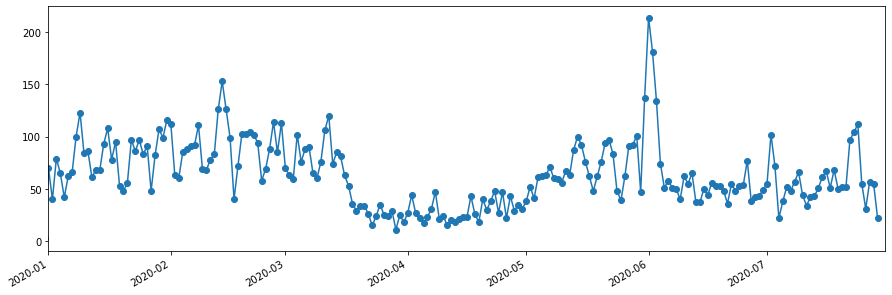

In [26]:
plt.figure(figsize = (15,5))
plt.scatter(day_count.index, day_count.values)
day_count.plot()
plt.xlim('2020-01-01','2020-07-31')
plt.show()

In [ ]:
# maybe we should exclude those arrested from 05-31 to 06-03

## Q1.1

## Q1.2 

## Q1.3 What neighborhoods are highly impacted by bail?

The following visualizations shows that monetary bail largely impacts those who live in areas with severe poverty. 
* Left: Number of monetary bail cases by zip code. 
    * (We can regenerate the image for entire year of 2020 once we have the data) 
* Right: From US Census Bureau ASC 5-year estimate from 2018. 
    * data and link to table stored at 'data/poverty'.
    * Maybe we can grab 2020 data

data          |  visualization
:-------------------------:|:-------------------------:
Case count of monetary bail by zip code | <img src="visualizations/monetary_bail_case_count.png" alt="drawing" width="800"/>  |
Percentage of population living under poverty by zip code | <img src="visualizations/percent_below_poverty.png" alt="drawing" width="800"/> | 

The following visualizations show that the median household income is higher than median bail amount (\$25K) in many zip codes. 
* Left: median monetary bail amount by zip code.
    * Median computed only for zipcodes that had 6 or more cases.  
    * Median bail amount is usually \$25K
    * We can regenerate the image once we have 2020 data available. 
* Right: median household income by zipcode
    * From US Cenus Bureau 2018 ASC 5-year estimate from 2018. 
    * data and link to table stored at 'data/income' 
    * Maybe we can grab 2020 data


data          |  visualization
:-------------------------:|:-------------------------:
Median monetary bail amount by zip code            | <img src="visualizations/bail_amount.png" alt="drawing" width="800"/> |  
Median household income by zip code | <img src="visualizations/income.png" alt="drawing" width="800"/>


## Q2.1 Relationship between bail type / amount and various factors

### Q: Are bail type and attorney type related?

In [235]:
df_bail_attorney = pd.crosstab(index = df['public_defender'], columns =df['bail_type'])
df_bail_attorney

bail_type,Monetary,Nominal,Nonmonetary,ROR,Unsecured
public_defender,,,,,
0,2346,1,16,771,974
1,3188,0,140,3149,2648


In [236]:
# since there are only a few nominal and non-monetary, combine them into 'other'
df_bail_attorney['Other'] = df_bail_attorney['Nominal'] + df_bail_attorney['Nonmonetary']

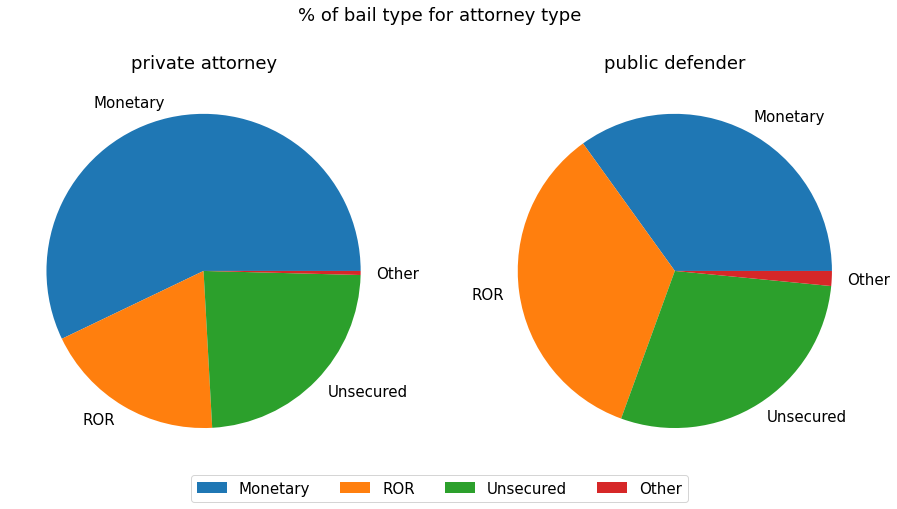

In [237]:
bail_types = ['Monetary','ROR', 'Unsecured', 'Other']
fig, ax = plt.subplots(ncols = 2, figsize = (15, 15))
plt.rcParams['font.size'] = 15
fig.suptitle('% of bail type for attorney type')
ax[0].pie(df_bail_attorney.loc[0,bail_types], labels = bail_types)
ax[0].set_title('private attorney')
ax[1].pie(df_bail_attorney.loc[1,bail_types], labels = bail_types)
ax[1].set_title('public defender')
# common legend
fig.subplots_adjust(top=1.35, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(1.1, 0), ncol=4)

plt.show()

In [238]:
# remove 'nominal' since we don't have enough cases 
df_bail_attorney.drop(columns = ['Nominal', 'Nonmonetary', 'Other'], inplace = True)

# chi-squared test
chi2, p, dof, ex = chi2_contingency(df_bail_attorney)
print('p-value of chi-square test: ', p)

p-value of chi-square test:  3.468844034416293e-130


* chi-square test tells us that **bail type and attorney type are related.**  
* Looking at the pie chart for cases with public defenders, around 1/3 of cases end up with monetary, ROR, or unsecured bail. In contrast, cases with private attorney representation ends up with higher proportion of monetary bail cases. 
* This might be because defendants with serious offenses (and therefore more likely to end up with monetary bail) may be more likely to seek representation by private attornies.

### Q: Is bail amount and attorney type related?

In [8]:
df_monetary = df[df['bail_type'] == 'Monetary'][['public_defender', 'bail_amount']]

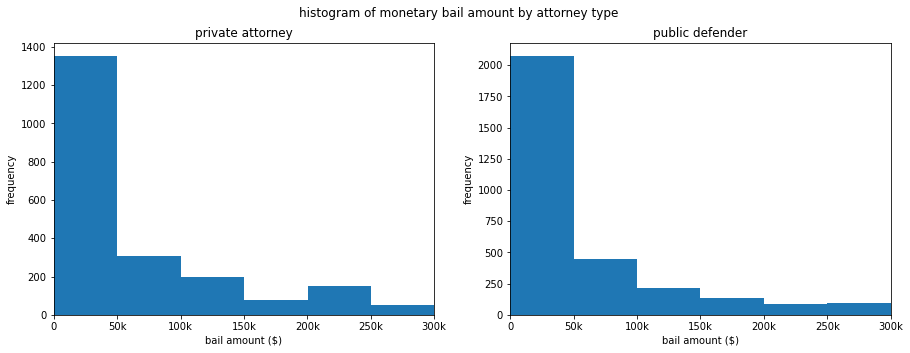

In [38]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5))
ax[0].hist(df_monetary[df_monetary["public_defender"] == 0].bail_amount, bins = 100)
ax[0].set_title('private attorney')
ax[1].hist(df_monetary[df_monetary["public_defender"] == 1].bail_amount, bins = 100)
ax[1].set_title('public defender')
for sub in ax:
    sub.set_xlim((0, 300000))
    sub.set_xlabel('bail amount ($)')
    sub.set_ylabel('frequency')
    sub.set_xticks(range(0, 350000, 50000))
    sub.set_xticklabels(['0','50k', '100k', '150k', '200k', '250k', '300k'])
    #plt.xticks(range(0, 350000, 50000), ['0','50k', '100k', '150k', '200k', '250k', '300k'])
plt.suptitle('histogram of monetary bail amount by attorney type')
plt.show()

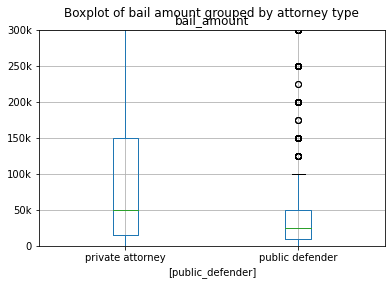

In [72]:
df_monetary.boxplot(column=['bail_amount'], by = ['public_defender'])
plt.ylim(0,300000)
plt.yticks(ticks = range(0, 350000, 50000), labels = ['0','50k','100k','150k','200k','250k','300k'])
plt.xticks(ticks = [1,2], labels = ['private attorney','public defender'])
plt.suptitle('Boxplot of bail amount grouped by attorney type')
plt.show()

In [50]:
print('Median monetary bail amount for cases with private attorney: ', df_monetary[df_monetary['public_defender'] == 0].bail_amount.median())
print('Median monetary bail amount for cases with public defender: ', df_monetary[df_monetary['public_defender'] == 1].bail_amount.median())

Median monetary bail amount for cases with private attorney:  50000.0
Median monetary bail amount for cases with public defender:  25000.0


* It seems like cases with private attornies have **higher monetary bail amount**.
* This may be due to the fact that defendants with serious offenses are more likely to hire private attornies.

## Q2.2

## Q2.3 What are the strongest factors determining bail type / bail amount?

* See Q2.1 for starters

### Prepare features

In [19]:
df.drop(columns = ['dob', 'arresting_officer', 'attorney', 'zip'], inplace = True)

### Correlations among categorical variables  
* Look at correlations among variables.  
* Use to select features for the predictive model
* Categorical variables to consider:
    * bail type
    * attorney type
    * arresting officer
    * magistrate 
    * zipcode
* Variables to add later: race, gender, offense type

In [76]:
def compute_cramers_V(contingency_table):
    # comptues Cramers'V measure from the given table
    # contingency_table: dataframe
    
    chi2 = chi2_contingency(contingency_table)[0]
    
    # sample size
    N = np.array(contingency_table).sum()
    k = min(contingency_table.shape)
    return np.sqrt(chi2 / (N*(k-1)))

In [121]:
def compute_cramersV_matrix(df, columns):
    # columns: list of columns of df with categorical variables
    n_variables = len(columns)
    V_matrix = np.identity(n_variables)
    
    for pair in itertools.combinations(range(n_variables),2):
        var1, var2 = pair
        cramersV = compute_cramers_V(pd.crosstab(index = df[columns[var1]], columns = df[columns[var2]]))
        V_matrix[var1, var2] = cramersV
        V_matrix[var2, var1] = cramersV

    return V_matrix

In [122]:
variables = ['public_defender', 'bail_type', 'zipcode_clean','arresting_officer', 'bail_set_by']
V_matrix = compute_cramersV_matrix(df, variables)

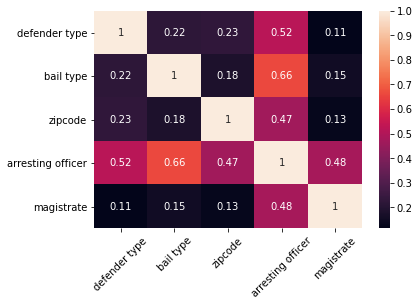

In [123]:
labels = ['defender type', 'bail type', 'zipcode', 'arresting officer', 'magistrate']
g = sns.heatmap(V_matrix, annot = True)
g.set_xticklabels(labels, rotation = 45)
g.set_yticklabels(labels, rotation = 0)
plt.show()

* Cramer's V score: [0,1], with 0: no association, 1: strong association
* It looks like 'arresting officer' is highly correlated with other variables. Probably because officers are in charge of specific types of offenses.  
* Caution: this correlation matrix doesn't remove low-frequency rows/columns during chi-square test. To validate results, should perform chi-square after adjusting frequency.
    * Ex) zipcode, arresting officer, and magistrate probably have a lot of low frequency categories

### Predictive Modeling (w/ updated data)

#### Review Features

Arrest Date

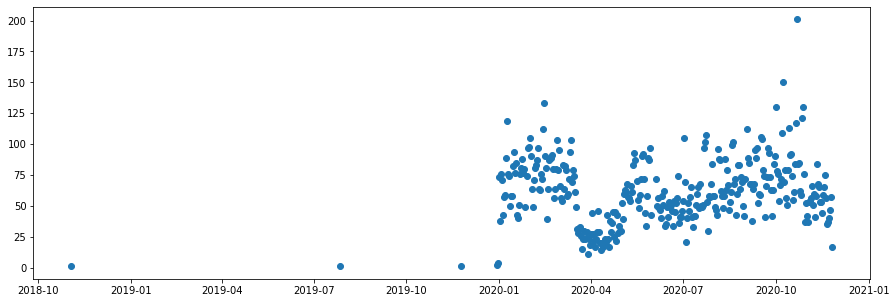

In [9]:
x = new['arrest_dt'].value_counts().index
y = new['arrest_dt'].value_counts().values

plt.figure(figsize=(15,5))
plt.plot_date(x, y)

# date or date range (e.g. month, quarter) not a very interpretable feature
# consider using day of the week

Arresting Officer

In [10]:
new['arresting_officer'].value_counts()

 Affiant                1329
 Balmer, James M.        285
 Rosa, Ricardo A.        260
 McCauley, Joseph J.     232
 Reilly, James M.        230
                        ... 
 O'Donnell, Sean           1
 Sweeney, Brandon          1
 Market, Matthew F.        1
 Tejeda, Jimmy             1
 Roesner, Francis J.       1
Name: arresting_officer, Length: 2885, dtype: int64

In [11]:
new['arresting_officer'].nunique()

# include top officers and bucket the rest into "other"

2885

Attorney

In [12]:
new['attorney'].nunique()

# overlaps with attorney type, don't include attorney as feature

497

Bail Date

TODO
* Look into what bail date is referring to (date bail is assigned? date bail is paid?)

Magistrate ('bail_set_by' column)

* Use top magistrates from earlier analysis (bucket rest into "other")?

Offense Date

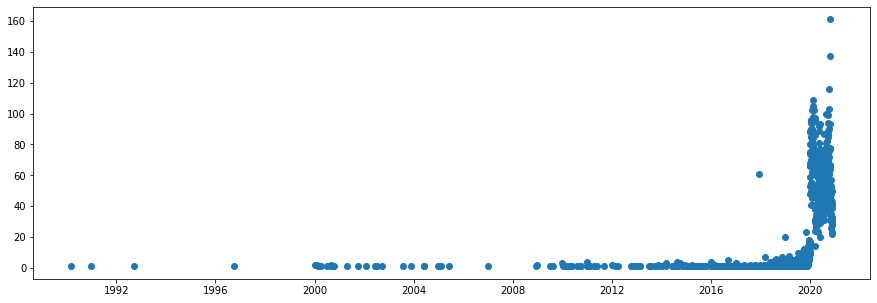

In [13]:
x = new['offense_date'].value_counts().index
y = new['offense_date'].value_counts().values

plt.figure(figsize=(15,5))
plt.plot_date(x, y)

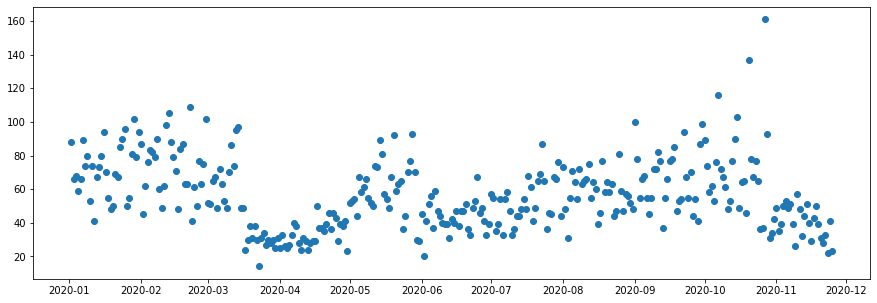

In [15]:
filtered_count = new[new['offense_date'] > datetime(2020, 1, 1)]['offense_date'].value_counts()

x = filtered_count.index
y = filtered_count.values

plt.figure(figsize=(15,5))
plt.plot_date(x, y)

# date or date range (e.g. month, quarter) not a very interpretable feature
# consider using day of the week

Zipcode

* Group areas?

In [26]:
new['zipcode_clean'].nunique()

585

Preliminary Hearing Date & Time

*Exclude from modeling*

* Bail is determined at initial appearance/arraignment, not at preliminary hearing ([American Bar](https://www.americanbar.org/groups/public_education/resources/law_related_education_network/how_courts_work/pretrial_appearances/#:~:text=The%20matter%20is%20set%20for,sets%20the%20amount%20of%20bail.))
* Preliminary hearings only apply to felonies ([American Bar](https://www.americanbar.org/groups/public_education/resources/law_related_education_network/how_courts_work/pretrial_appearances/#:~:text=The%20matter%20is%20set%20for,sets%20the%20amount%20of%20bail.))
* Prelims only happen when the defendant pleads not guilty in arraignment ([Nolo](https://www.nolo.com/legal-encyclopedia/all-about-preliminary-hearings-or-prelims.html))
* Defendant may make motion to reduce bail at prelims ([PA law firm](https://goldsteinmehta.com/blog/what-happens-at-the-preliminary-hearing))

Features to include in model:
* age group
* arrest date (day of week)
* arresting officer
* attorney type
* magistrate (bail set by)
* offense date (day of week)
* offense type
* race
* sex

Potential targets:
* bail amount
* bail set bin
* bail paid (yes/no)
* bail type

#### Check for Multicolliniearity (VIF)

#### Regression analysis

#### Classification

## Q2.4